In [1]:
import sys
import gym
import numpy as np
import cv2
import requests
import time
import json
import matplotlib.pyplot as plt
from stable_baselines3 import DDPG  # RL algorithm
from stable_baselines3.common.vec_env import DummyVecEnv

sys.path.append("../thread")
from camera_thread import CameraThread
from control_motors import ControlMotor

In [9]:
def detect_via_api(api_url: str, image: list) -> dict[str, str]:
    try:
        _, image_bytes = cv2.imencode(".jpg", image)
        # PILLOW
        # image_bytes = BytesIO()
        # image.save(image_bytes, format="JPEG")
        
        files = {'image': ('image.jpg', image_bytes, 'image/jpeg')}

        # Make the POST request with the image file
        response = requests.post(api_url, files=files)

        # Check if the request was successful (status code 200)
        if response.status_code == 200:
            print("Image successfully posted to the API.")
            response_dict = json.loads(response.content.decode())
            return response_dict
        else:
            print(f"Error: {response.status_code} - {response.text}")
    except Exception as e:
        raise Exception

In [10]:
camera_thread = CameraThread()
control_motor = ControlMotor()
camera_thread.start()
control_motor.start()

In [30]:
control_motor.send_angles_api([26, 50], 1)

In [53]:
current = time.time()
api_url = "http://172.23.161.109:8300/detect_grape_bunch"
# image_path = "./2024-03-30 19:02:08/draw/draw_0.jpg"
# image = cv2.imread(image_path)
image = camera_thread.get_latest_frame()
res = detect_via_api(api_url, image)
done = time.time()

Image successfully posted to the API.


In [54]:
w, h, c = image.shape
image_center = (h // 2, w // 2)

bunch_xyxy = res["bunch"][:4]
bunch_x1, bunch_y1, bunch_x2, bunch_y2 = map(int, bunch_xyxy)
bunch_center = ((bunch_x1 + bunch_x2) // 2, (bunch_y1 + bunch_y2) // 2)

In [58]:
dis_x, dis_y = image_center[0] - bunch_center[0], image_center[1] - bunch_center[1]

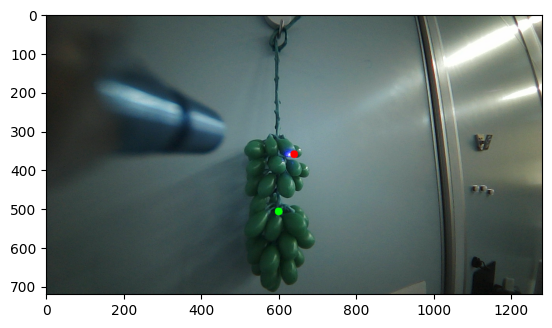

In [55]:
cv2.circle(image, image_center, 10, (255, 0, 0), -1)
cv2.circle(image, bunch_center, 10, (0, 255, 0), -1)
plt.imshow(image)

In [29]:
camera_thread.stop()
camera_thread.join()
control_motor.stop()
control_motor.join()

In [3]:
ACTION_SPACE = gym.spaces.Box(low=-1, high=1, shape=(2,), dtype=np.float32)

In [9]:
CameraControl = gym.Env()

In [11]:
CameraControl.observation_space = gym.spaces.Box(low=-np.inf, high=np.inf, shape=(4,), dtype=np.float32)
CameraControl.action_space = gym.spaces.Box(low=-1, high=1, shape=(2,), dtype=np.float32)

In [ ]:
CameraControl.get

In [9]:
# Define RL environment
class CameraControlEnv(gym.Env):
    def __init__(self):
        # Initialize environment parameters
        self.observation_space = gym.spaces.Box(low=-np.inf, high=np.inf, shape=(state_dim,), dtype=np.float32)
        self.action_space = gym.spaces.Box(low=-1, high=1, shape=(action_dim,), dtype=np.float32)
        self.camera_thread = CameraThread()
        self.control_motor = ControlMotor()
        self.api_url = "http://172.23.161.109:8300/detect_grape_bunch"
        self.camera_thread.start()
        self.control_motor.start()

    def reset(self):
        # Reset environment to initial state
        return self.get_observation()

    def step(self, action):
        # Execute action and return next state, reward, done, info
        self.take_action(action)
        next_state = self.get_observation()  # Get next state
        reward = self.calculate_reward(next_state)  # Calculate reward
        done = self.check_done()  # Check termination condition
        info = {}  # Additional info
        return next_state, reward, done, info

    def get_observation(self):
        # Get current observation (state) of the environment
        image = self.camera_thread.get_latest_frame()
        res = detect_via_api(self.api_url, image)

        w, h, c = image.shape
        image_center = (h // 2, w // 2)

        bunch_xyxy = res["bunch"][:4]
        bunch_x1, bunch_y1, bunch_x2, bunch_y2 = map(int, bunch_xyxy)
        bunch_center = ((bunch_x1 + bunch_x2) // 2, (bunch_y1 + bunch_y2) // 2)

        # Calculate displacement between image center and target center
        self.dis_x, self.dis_y = image_center[0] - bunch_center[0], image_center[1] - bunch_center[1]

        # Combine displacement values with other relevant information as the observation
        observation = np.array([self.dis_x, self.dis_y])  # Add other relevant information if needed
        return observation

    def take_action(self, action):
        # Convert action to servo motor angles and move motors
        angles = self.convert_action_to_angles(action)
        self.control_motor.send_angles_api(angles)

    def calculate_reward(self, state):
        # Reward proximity to target (negative distance)
        reward_proximity = -np.sqrt(state[0]**2 + state[1]**2)  # Negative Euclidean distance
        
        # Penalize large deviations from the target
        deviation_penalty = -np.abs(self.dis_x) - np.abs(self.dis_y)  # Penalize absolute distance
        
        # Provide a final reward if the episode is done (target reached or maximum steps reached)
        final_reward = 100 if done else 0
        
        # Combine individual reward components
        reward = reward_proximity + deviation_penalty + final_reward
        
        return reward

    def check_done(self):
        # Check termination condition (e.g., if camera center is close enough to the target object)
        # Implement termination condition
        if self.dis_x > 10 or self.dis_x < 10 and self.dis_y > 10 or self.dis_y < 10:
            done = True
        else:
            done = False    
        return done

    def convert_action_to_angles(self, action):
        # Convert RL action to servo motor angles
        # Implement code to map action space to servo motor angles
        return angles

AssertionError: Expect all shape elements to be an integer, actual type: (<class 'ellipsis'>,)

In [10]:
def evaluate_policy(model, env, n_eval_episodes=10):
    total_rewards = []
    for _ in range(n_eval_episodes):
        obs = env.reset()
        episode_reward = 0
        done = False
        while not done:
            action, _ = model.predict(obs, deterministic=True)
            obs, reward, done, _ = env.step(action)
            episode_reward += reward
        total_rewards.append(episode_reward)
    mean_reward = np.mean(total_rewards)
    std_reward = np.std(total_rewards)
    return mean_reward, std_reward